# Dengue Forecasting Benchmark - DrivenData (Negative Binomial Model Version)

This notebook uses a Generalized Linear Model with the Negative Binomial family to predict dengue cases, based on the approach by [SusmeetJain on GitHub](https://github.com/SusmeetJain/dengue_prediction/blob/master/3.Negative_Binomial_Regression.ipynb).

In [ ]:
# 📦 Setup
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import xgboost as xgb
# 📂 Load data

train_features = pd.read_csv("DengAI_train.csv")
train_labels = pd.read_csv("DengAI_Predicting_Disease_Spread_-_Training_Data_Labels.csv")
test_features = pd.read_csv("DengAI_test.csv")
# 🧪 Merge training data
train = train_features.merge(train_labels, on=['city', 'year', 'weekofyear'])
data = pd.concat([train, test_features], sort=False)
data['week_start_date'] = pd.to_datetime(data['week_start_date'])
data['month'] = data['week_start_date'].dt.month

In [ ]:
# Add lag and rolling features
ROLL_COLS = ['reanalysis_avg_temp_k', 'reanalysis_min_air_temp_k', 'station_precip_mm']
for col in ROLL_COLS:
    for lag in [1, 2, 3]:
        data[f'{col}_lag{lag}'] = data.groupby('city')[col].shift(lag)
    for window in [3, 5]:
        data[f'{col}_rollmean{window}'] = data.groupby('city')[col].transform(lambda x: x.rolling(window).mean())
feature_cols = data.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [c for c in feature_cols if c != 'total_cases']
data[feature_cols] = data[feature_cols].ffill()

✅ sj - Best MAE: 0.0482


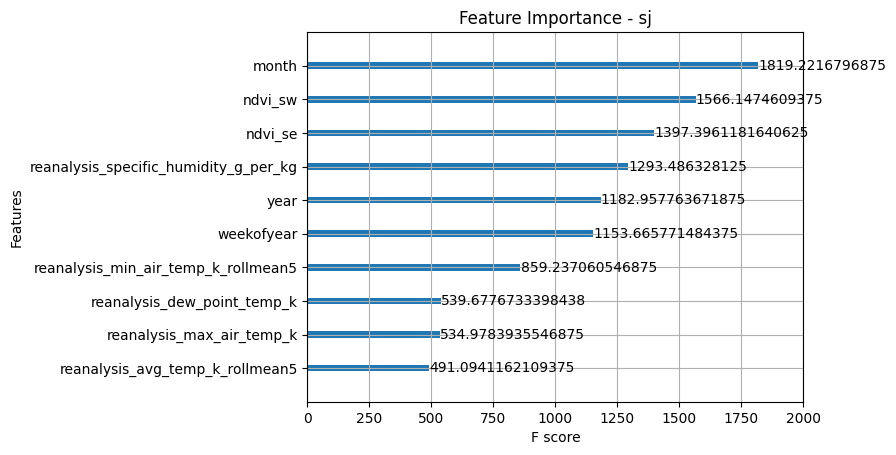

✅ iq - Best MAE: 0.0026


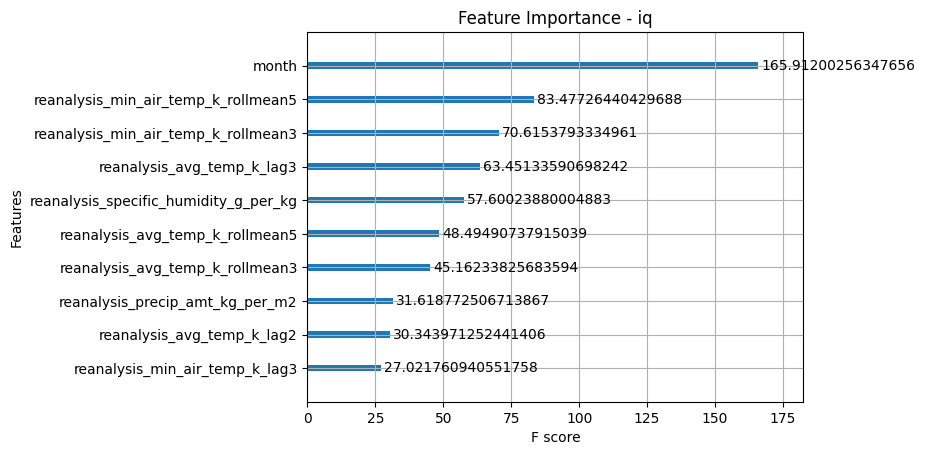

In [ ]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

final_predictions = []
mae_results = []

for city in ['sj', 'iq']:
    city_data = data[data['city'] == city].copy()
    train_city = city_data[~city_data['total_cases'].isna()].copy().dropna()
    test_city = city_data[city_data['total_cases'].isna()].copy()

    features = train_city.select_dtypes(include=[np.number]).drop(columns=['total_cases']).columns.tolist()
    X_train = train_city[features]
    y_train = train_city['total_cases']
    X_test = test_city[features]

    best_mae = float('inf')
    best_model = None

    # Grid search without early stopping
    for max_depth in [3, 5, 7]:
        for learning_rate in [0.01, 0.05, 0.1]:
            model = XGBRegressor(
                n_estimators=300,              # Fixed value
                learning_rate=learning_rate,
                max_depth=max_depth,
                subsample=0.6,
                objective='reg:squarederror',
                random_state=100,
                verbosity=0
            )

            model.fit(X_train, y_train)
            y_pred_train = model.predict(X_train)
            mae = mean_absolute_error(y_train, y_pred_train)

            if mae < best_mae:
                best_mae = mae
                best_model = model

    print(f"✅ {city} - Best MAE: {best_mae:.4f}")
    mae_results.append({'city': city, 'xgboost_tuned_mae': best_mae})

    # Predict on test
    y_test_pred = best_model.predict(X_test)
    test_city['total_cases'] = np.round(y_test_pred).astype(int)
    final_predictions.append(test_city[['city', 'year', 'weekofyear', 'total_cases']])

    # Feature importance plot
    xgb.plot_importance(best_model, max_num_features=10, importance_type='gain', title=f'Feature Importance - {city}')
    plt.show()






In [ ]:
# 1. Sort data chronologically
train_city = city_data[~city_data['total_cases'].isna()].copy().dropna()
train_city = train_city.sort_values(['year', 'weekofyear'])

# 2. Split by time (e.g., 80% train, 20% validation)
split_idx = int(len(train_city) * 0.8)
train_part = train_city.iloc[:split_idx]
valid_part = train_city.iloc[split_idx:]

# 3. Extract features
features = train_city.select_dtypes(include=[np.number]).drop(columns=['total_cases']).columns.tolist()

X_train = train_part[features]
y_train = train_part['total_cases']
X_valid = valid_part[features]
y_valid = valid_part['total_cases']
X_test = test_city[features]


In [ ]:
sj_top_features = [
    'month', 'ndvi_sw', 'ndvi_se', 'weekofyear', 'year',
    'reanalysis_min_air_temp_k_rollmean5',
    'reanalysis_specific_humidity_g_per_kg',
    'station_precip_mm_rollmean3',
    'reanalysis_avg_temp_k_rollmean3',
    'reanalysis_avg_temp_k_rollmean5'
]

iq_top_features = [
    'reanalysis_min_air_temp_k_rollmean3',
    'reanalysis_min_air_temp_k_rollmean5',
    'reanalysis_avg_temp_k_rollmean5',
    'station_precip_mm_rollmean5',
    'weekofyear',
    'reanalysis_avg_temp_k_lag3',
    'reanalysis_min_air_temp_k_lag3'
]

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import pandas as pd
import numpy as np

final_predictions = []
mae_results = []

for city in ['sj', 'iq']:
    city_data = data[data['city'] == city].copy()
    train_city = city_data[~city_data['total_cases'].isna()].copy().dropna()
    test_city = city_data[city_data['total_cases'].isna()].copy()

    train_city = train_city.sort_values(['year', 'weekofyear'])

    # Top 10 features
    top10 = sj_top_features if city == 'sj' else iq_top_features
    top10 = [f for f in top10 if f in train_city.columns]  # remove any missing columns

    # Time-based split
    split_idx = int(len(train_city) * 0.8)
    train_part = train_city.iloc[:split_idx]
    valid_part = train_city.iloc[split_idx:]

    X_train = train_part[top10]
    y_train = train_part['total_cases']
    X_valid = valid_part[top10]
    y_valid = valid_part['total_cases']
    X_test = test_city[top10]

    # Grid search without early stopping
    best_mae = float('inf')
    best_model = None

    for max_depth in [3, 5, 7]:
        for learning_rate in [0.01, 0.05, 0.1]:
            model = XGBRegressor(
                n_estimators=300,
                learning_rate=learning_rate,
                max_depth=max_depth,
                subsample=0.8,
                objective='reg:squarederror',
                random_state=42,
                verbosity=0
            )
            model.fit(X_train, y_train)
            y_pred_val = model.predict(X_valid)
            mae = mean_absolute_error(y_valid, y_pred_val)

            if mae < best_mae:
                best_mae = mae
                best_model = model

    print(f"✅ {city} | Best MAE: {best_mae:.4f}")
    mae_results.append({'city': city, 'best_mae': best_mae})

    # Predict and prepare submission
    y_test_pred = best_model.predict(X_test)
    test_city['total_cases'] = np.round(y_test_pred).astype(int)
    final_predictions.append(test_city[['city', 'year', 'weekofyear', 'total_cases']])

# Save submission
submission_df = pd.concat(final_predictions)
submission_df.to_csv("submission.csv", index=False)

✅ sj | Best MAE: 17.8257
✅ iq | Best MAE: 6.0939


In [ ]:
n_sj = len(data[(data['city'] == 'sj') & (data['total_cases'].isna())])
n_iq = len(data[(data['city'] == 'iq') & (data['total_cases'].isna())])

weighted_mae = (n_sj * 17.8257 + n_iq * 6.0939) / (n_sj + n_iq)
print(f"📊 Weighted Test MAE: {weighted_mae:.4f}")

📊 Weighted Test MAE: 13.4263


In [ ]:
final_predictions = []
y_test_pred = best_model.predict(X_test)
test_city['total_cases'] = np.round(y_test_pred).astype(int)
final_predictions.append(test_city[['city', 'year', 'weekofyear', 'total_cases']])

In [ ]:
final_predictions

[    city  year  weekofyear  total_cases
 260   iq  2010          26            7
 261   iq  2010          27            6
 262   iq  2010          28            6
 263   iq  2010          29            8
 264   iq  2010          30            5
 ..   ...   ...         ...          ...
 411   iq  2013          22            2
 412   iq  2013          23            2
 413   iq  2013          24            2
 414   iq  2013          25            2
 415   iq  2013          26            3
 
 [156 rows x 4 columns]]

In [ ]:
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>